In [1]:
BASE_PATH = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/"

from sys import path

path.append(f"{BASE_PATH}Scripts/")
path.append(f"/home/diegodp/Documents/PhD/Paper_2/InsituEMDCorrelation/Scripts/EMD/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import makedirs
from EMDComparison import LcurveSolOEMD as lc

from datetime import datetime, timedelta
from importsProj3.signalHelpers import compareTS, new_plot_format, plot_super_summary, extractDiscreteExamples, caseCreation
import idlsave
from collections import namedtuple

### General Setup of lightcurves

In [2]:
# Set the unsafe, target safe, and dataFolder
unsafe_dir = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/"
saveFolder = f"{unsafe_dir}ISSI/New_Method/"
dataFolder = f"/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/ISSI/data/"

# Parameters for DELETION, showing FIG
DELETE = False
SHOWFIG = True

# We set a large possible set of periodicities
PeriodMinMax = [5, 20]
makedirs(saveFolder, exist_ok=True)

# IN SITU DATA
df_is = pd.read_csv(f"{dataFolder}small_ch_in_situ.csv")
df_is.index = pd.to_datetime(df_is["Time"])
del df_is["Time"]

insituParams = ["Vr", "Mf", "Np", "T", "Br"]
df_is = df_is[insituParams]

# Attempt to read in dataframes
try: 
    df_171 = pd.read_csv(f'{dataFolder}small_ch_171_lc_in.csv', index_col="Time")
    df_193 = pd.read_csv(f'{dataFolder}small_ch_193_lc_in.csv', index_col="Time")
    df_flux = pd.read_csv(f'{dataFolder}ch_flux.csv', index_col="Time")
    print("Loaded csv successfully")

    for _df in (df_171, df_193, df_flux):
        _df.index = pd.to_datetime(_df.index)

except FileNotFoundError:
    # REMOTE DATA
    rs_171 = idlsave.read(f'{dataFolder}small_ch_171_lc_in.sav', verbose=False)
    rs_193 = idlsave.read(f'{dataFolder}small_ch_193_lc_in.sav', verbose=False)
    ch_flux = idlsave.read(f'{dataFolder}chflux.sav', verbose=False)

    # 171 and 193 observations
    time_array = rs_171.date_obs_171.copy()
    time_array = [t.decode() for t in list(time_array)]

    df_171 = pd.DataFrame(
        {
            'plume': rs_171.lc_171_plume_in,
            'cbpoint': rs_171.lc_171_bp_in,
            'chplume': rs_171.lc_171_ch_plume_in,
            'chole': rs_171.lc_171_ch_in,
            'qsun': rs_171.lc_171_qs_in,
        },
        index=pd.to_datetime(time_array))


    df_193 = pd.DataFrame(
        {
            'plume': rs_193.lc_193_plume_in,
            'cbpoint': rs_193.lc_193_bp_in,
            'chplume': rs_193.lc_193_ch_plume_in,
            'chole': rs_193.lc_193_ch_in,
            'qsun': rs_193.lc_193_qs_in,
        },
        index=pd.to_datetime(time_array))

    # Open and Bright point flux
    flux_time = ch_flux.hmitimes.copy()
    flux_time = [t.decode() for t in list(flux_time)]

    df_flux = pd.DataFrame(
        {
            "ch_open_flux": ch_flux.chofluxes,
            "ch_bpoint_flux": ch_flux.chbpfluxes,
        },
        index=pd.to_datetime(flux_time, format="%Y.%m.%d_%H:%M:%S_TAI"))


    df_171.to_csv(f'{dataFolder}small_ch_171_lc_in.csv', index_label="Time")
    df_193.to_csv(f'{dataFolder}small_ch_193_lc_in.csv', index_label="Time")
    df_flux.to_csv(f'{dataFolder}ch_flux.csv', index_label="Time")

Loaded csv successfully


## Define the API for compareTS

In [3]:
 
def combinedPlot(
                lcDic=None, 
                dfPSP=None,
                base_folder=None,
                PeriodMinMax=[5, 20],
                showSpeed=True,
                spcSpeeds = (None, None),
                regions= None,
                superSummary = False,
                ):

                new_plot_format(
                    dfInsitu=dfPSP,
                    lcDic=lcDic,
                    regions=regions,
                    base_folder=base_folder,
                    period=PeriodMinMax,
                    addResidual = False,
                    showSpeed=showSpeed,
                    addEMDLcurves = True,
                    SPCKernelName = "psp",
                    spcSpeeds=spcSpeeds,
                )

# Create test cases

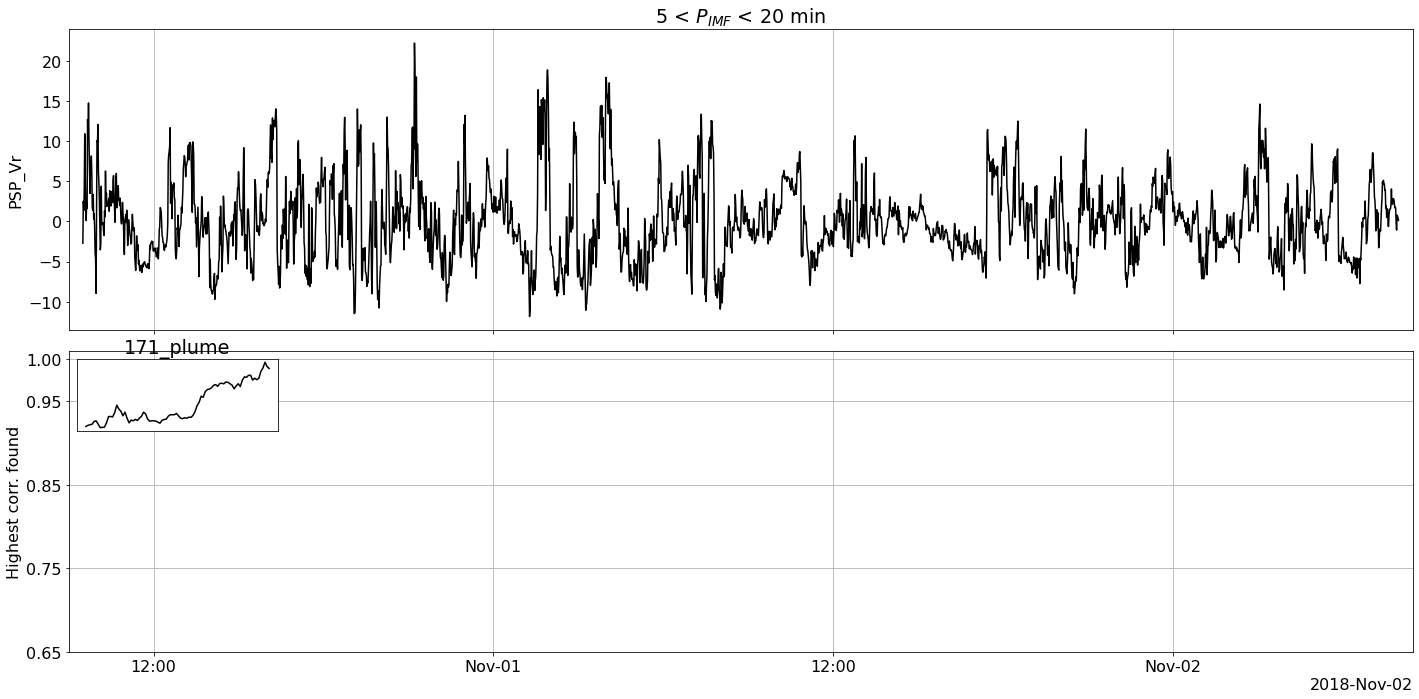

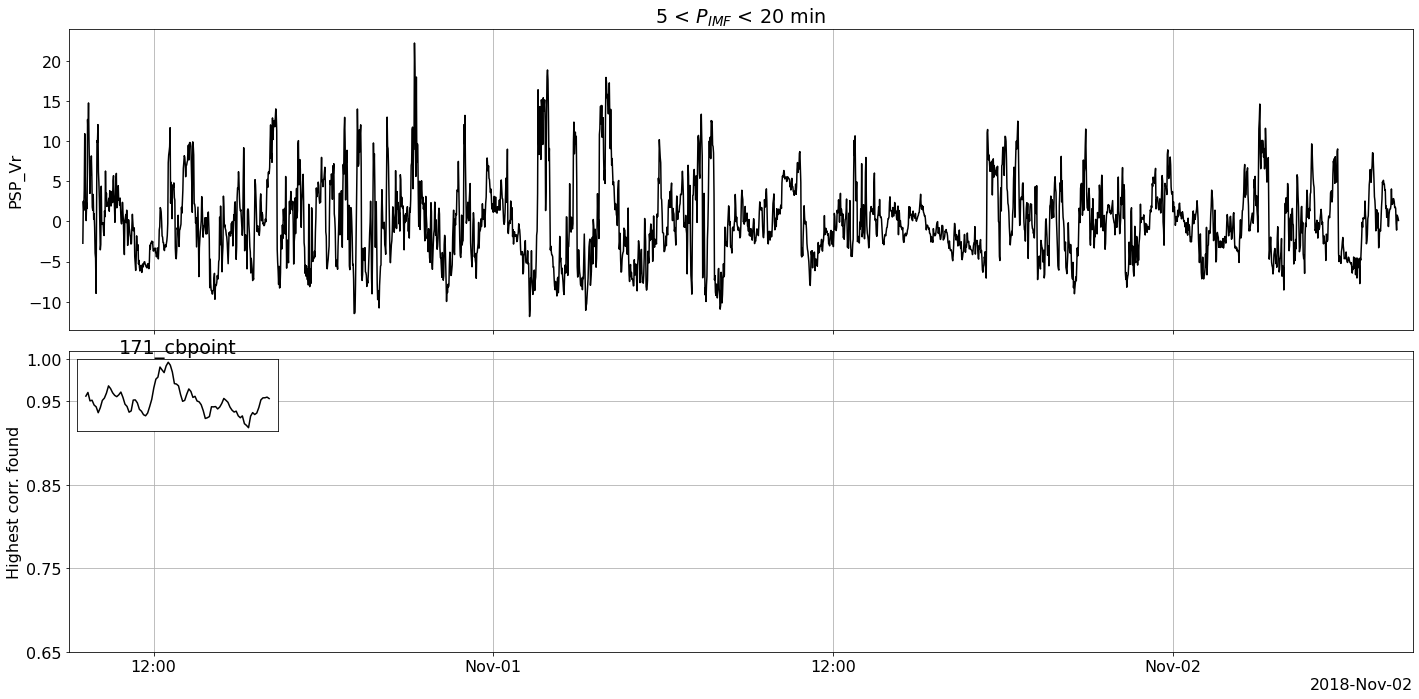

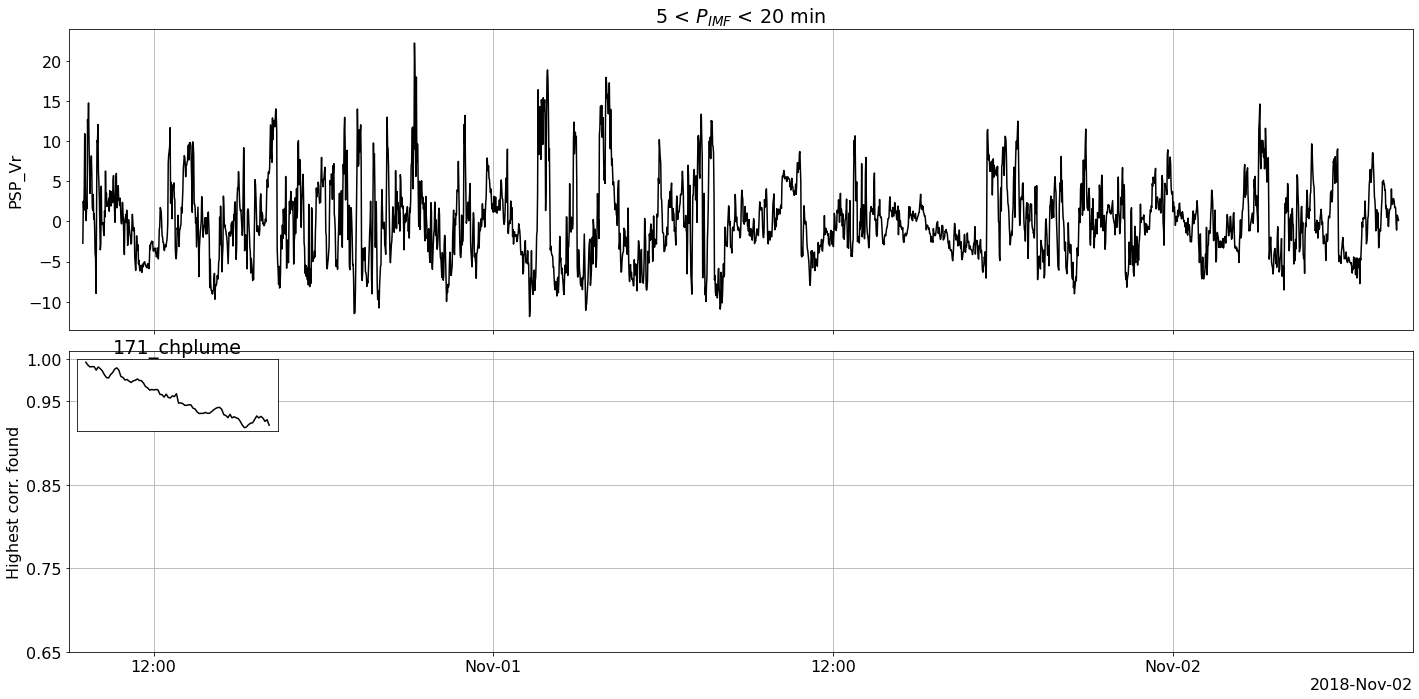

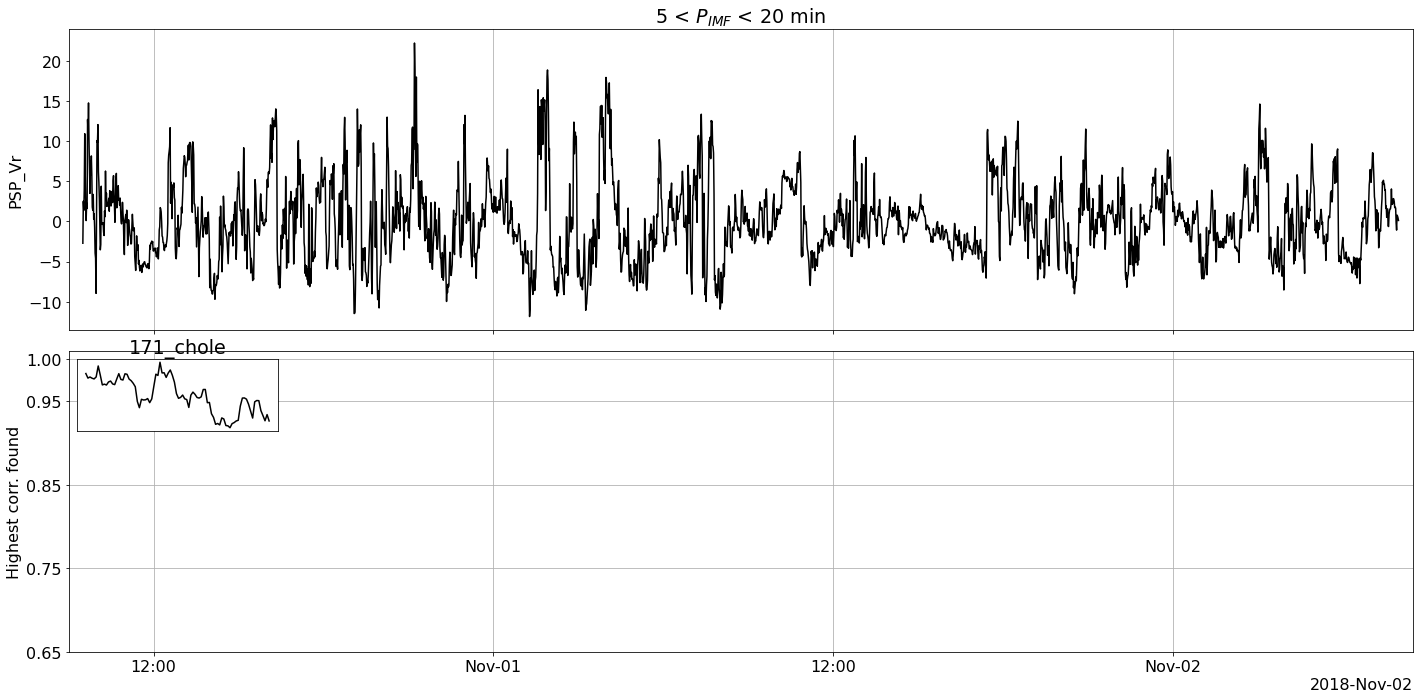

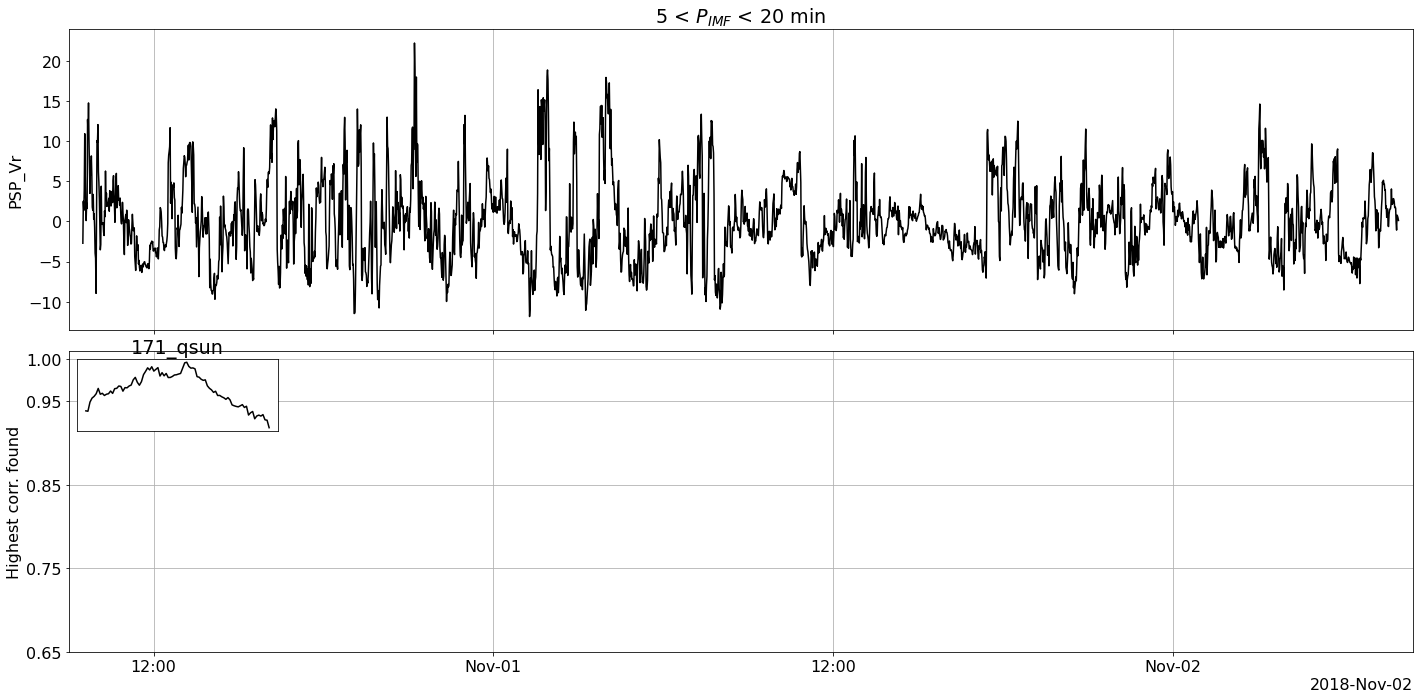

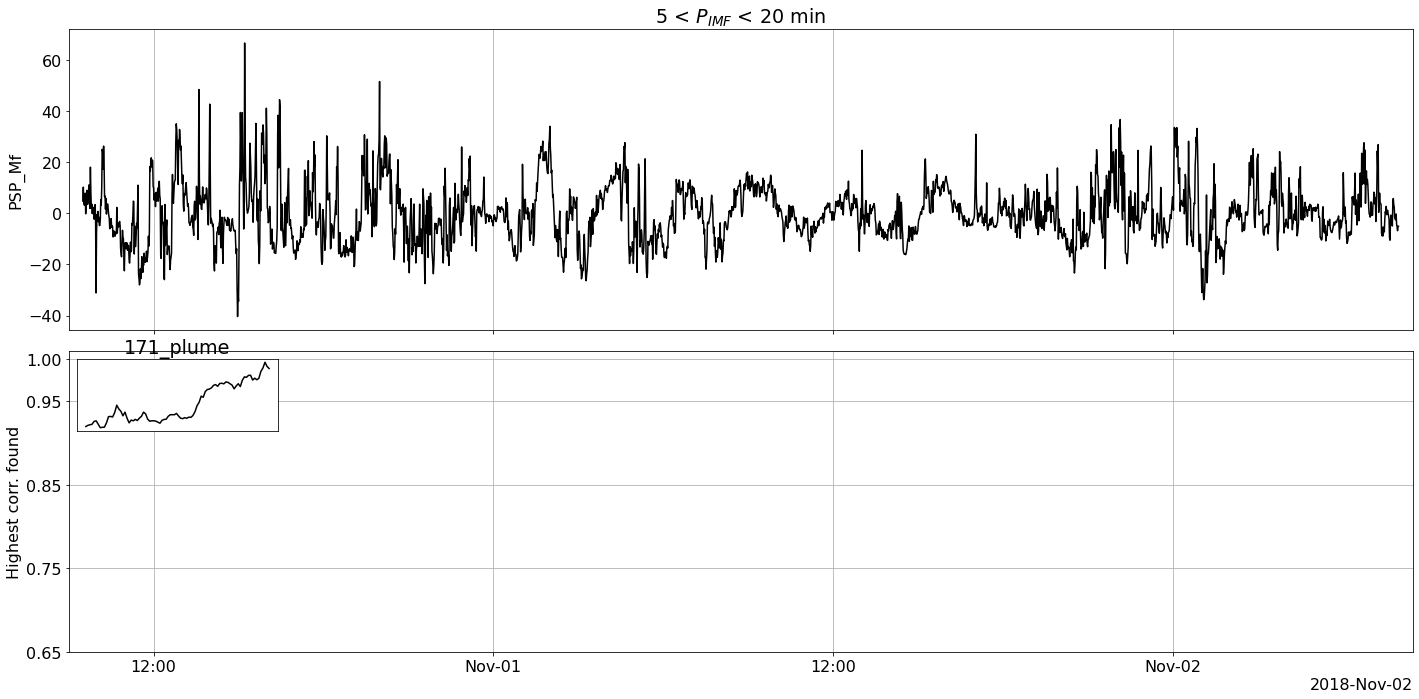

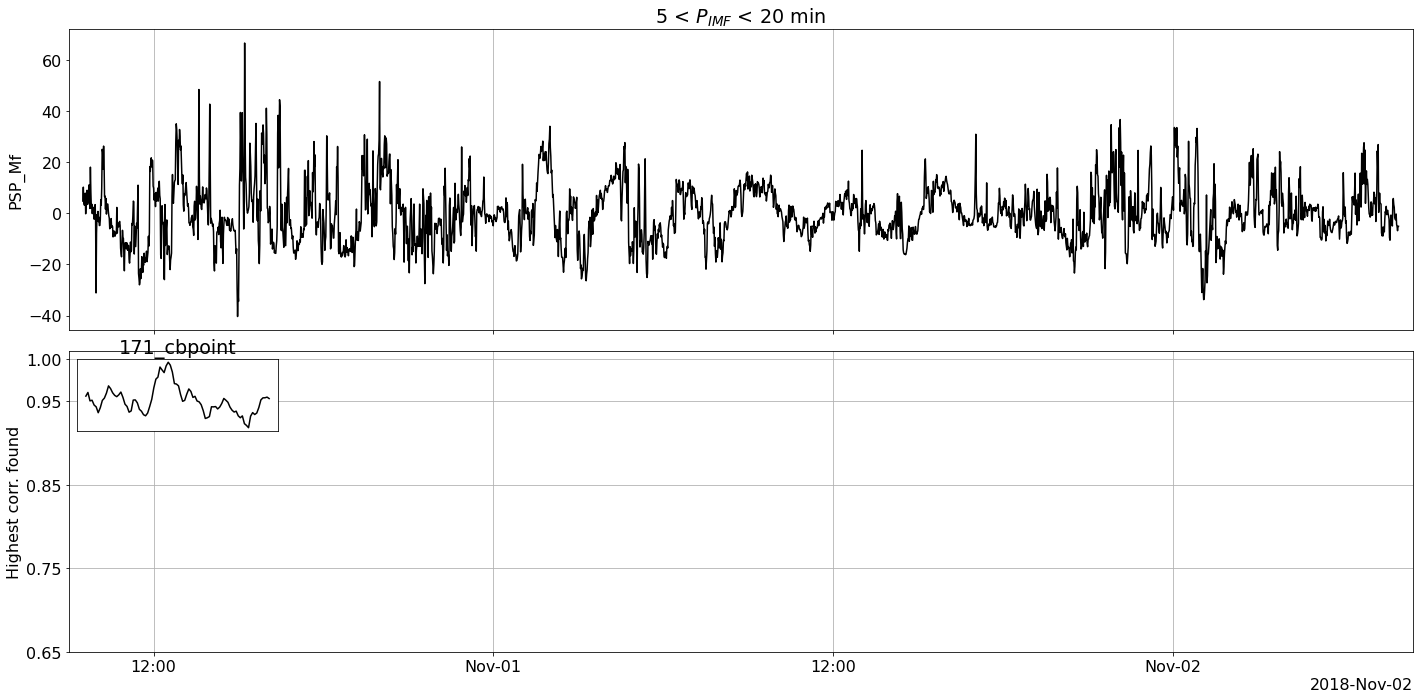

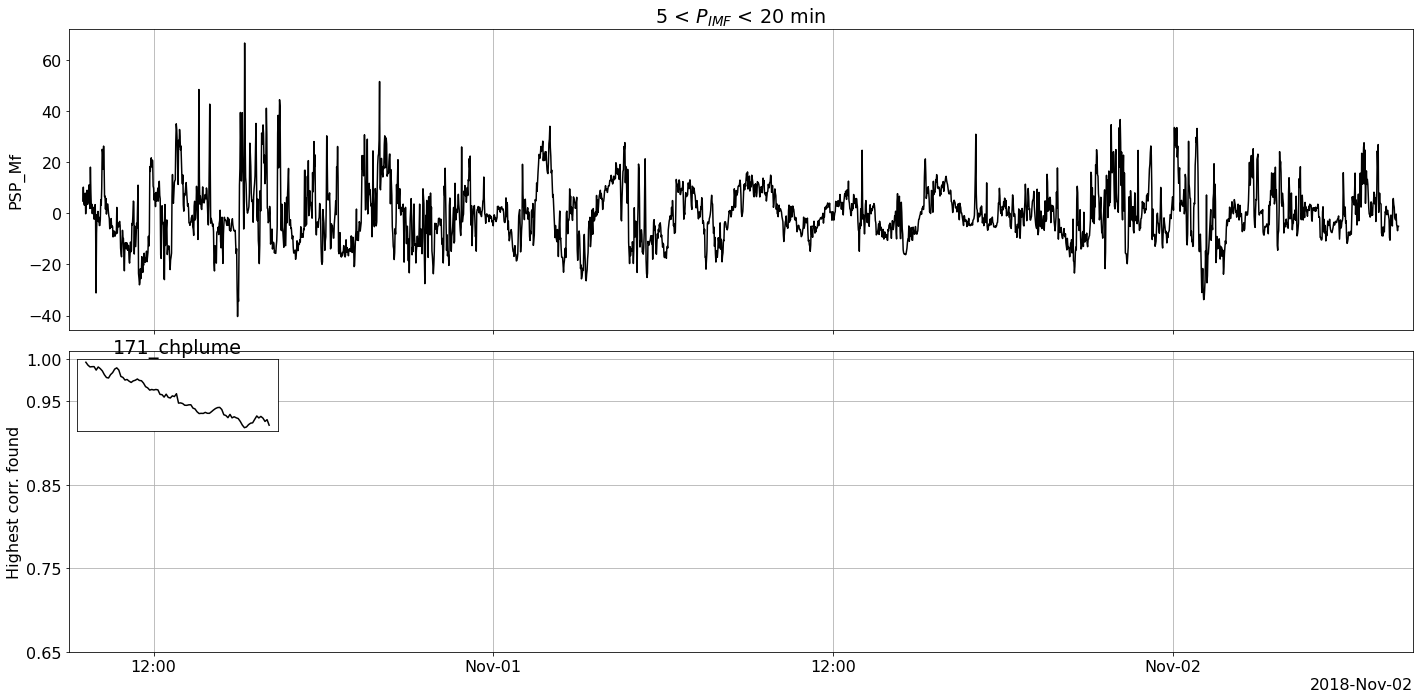

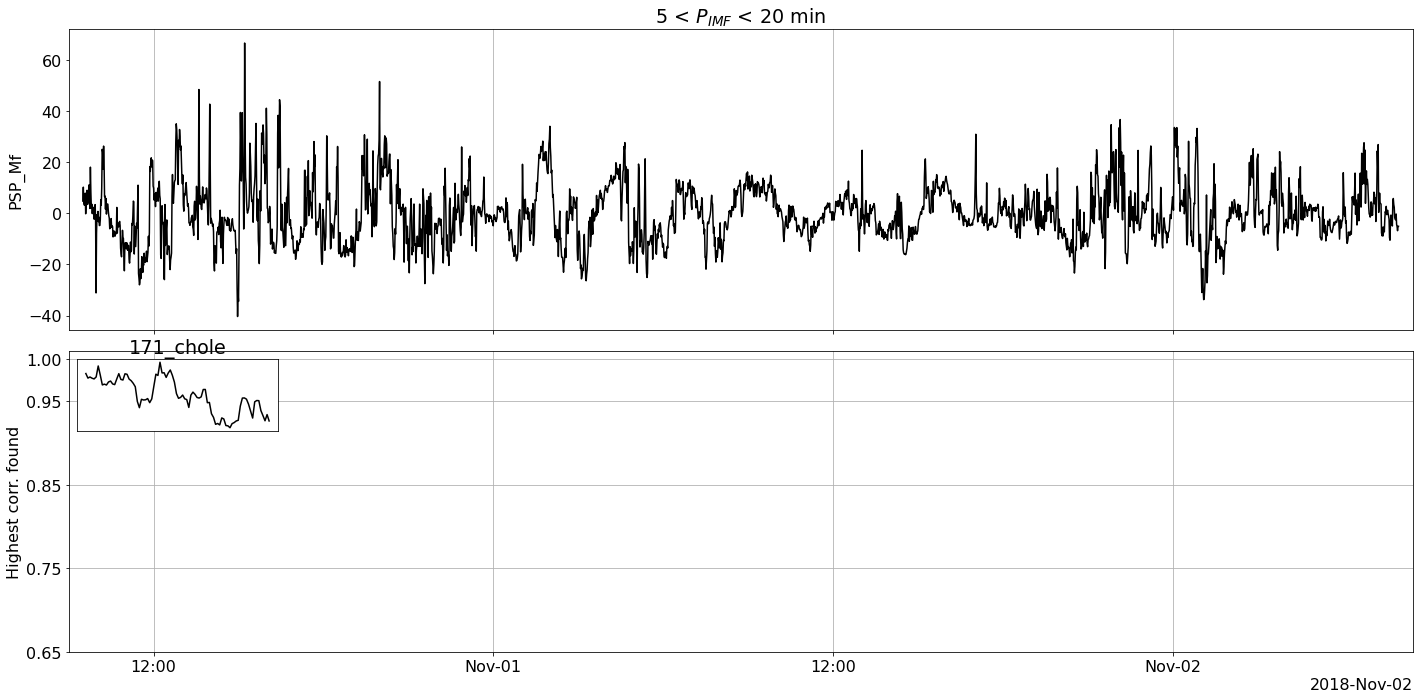

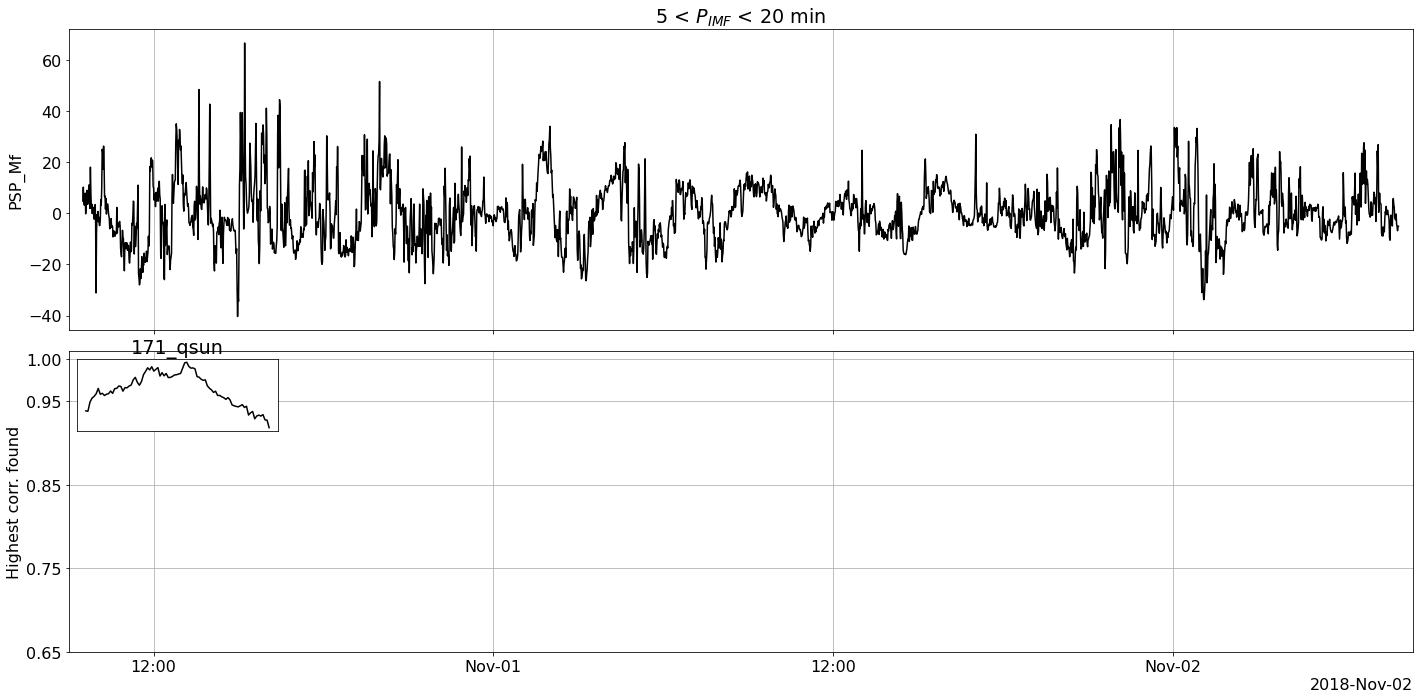

KeyboardInterrupt: 

In [4]:
"""
Generate the cases for all possible SolO - SHORT times (every hour)
"""
AIACases = {
   "shortTimes":(datetime(2018, 10, 29, 16), datetime(2018, 10, 30, 23, 50)),
   "longTimes":(datetime(2018, 10, 31, 8), datetime(2018, 11, 2, 8)),
   "shortDuration":3,
   "caseName":"SDO_AIA",
   "shortDisplacement":3,
   "MarginHours":24,
   "savePicklePath":"/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/ISSI/cases/AIAcases.pickle",
   "forceCreate": True,
}

# Get the cases and put them together with respective AIA observations in Dic
cases = caseCreation(**AIACases)
AIACase = namedtuple("AIACase", ["name", "df", "regions", "cases"])
LongCase = namedtuple("LongCase", ["name", "df"])

shortDFDic = [AIACase(171, df_171.copy(), df_171.columns, cases), AIACase(193, df_193.copy(), df_193.columns, cases)]
longDF = LongCase("PSP", df_is.copy())

def emdAndCompareCases(shortDFDic, longDF, detrendBoxWidth=200, showFig=False, speedLim=(300, 500)):
   """
      Perform EMD and Compare a short and a Long dataframe
      Args:
         shortDFDic: A list containing the shortDF class, including "name", "df", "regions", and "cases"
   """
   loSpeed, hiSpeed = speedLim
   _dfLong = longDF.df.copy()
   _dfLong.columns = [f"{longDF.name}_{i}" for i in _dfLong.columns]
   cadLong = (_dfLong.index[1] - _dfLong.index[0]).seconds

   for dfCase in shortDFDic:
      (shortTimesList, longTimesList, caseNamesList, refLocations) = extractDiscreteExamples(dfCase.cases, margin=cases[0]["MARGINHOURSLONG"])
      _dfShort = dfCase.df.copy()
      _dfShort.columns = [ f"{dfCase.name}_{i}" for i in _dfShort.columns] 
      cadShort = (_dfShort.index[1] - _dfShort.index[0]).seconds

      assert cadLong == cadShort, "Cadence of short object not equal to cad. of long Object"
      for index, shortTimes in enumerate(shortTimesList):
         dirName = f"{caseNamesList[index]}"
         _dfShortCut = _dfShort[shortTimes[0]:shortTimes[1]]
         _dfLongCut = _dfLong[longTimesList[index][0]: longTimesList[index][1]]
         _specificFolder = f"{saveFolder}{dirName}/"

         if refLocations!= []:
            _expectedLocationList = refLocations[index]
         else:
            _expectedLocationList = False

         # TODO: Check in importsProj3 why there is a bug with showSpeed
         # TODO: verify that code is saving correctly
         # TODO: Make new individual plots for larger number of examples
         # TODO: Make summary plots and put in paper
         compareTS(
            dfSelf = _dfShortCut,
            dfOther = _dfLongCut,
            cadSelf=cadShort,
            cadOther=cadLong,
            labelOther=longDF.name,
            winDispList=[cadShort],
            corrThrPlotList=np.arange(0.65, 1, 0.05),
            PeriodMinMax=PeriodMinMax,
            showLocationList=False,
            filterPeriods=True,
            savePath=_specificFolder,
            useRealTime=True,
            expectedLocationList=_expectedLocationList,
            detrend_box_width=detrendBoxWidth,
            showFig=showFig,
            renormalize=False,
            showSpeed=False,
            HISPEED=loSpeed,
            LOSPEED=hiSpeed,
            SPCKernelName=longDF.name.lower(),  # Should ensure that using SPC name
         )

emdAndCompareCases(shortDFDic, longDF, showFig=True, )


### Compare a set of CSV files to created Cases

In [ ]:
def firstCase():
    # Selecting ~ 10 hours of in situ observations with 14 switchbacks
    timeInsitu = (datetime(2018, 10, 31, 12), datetime(2018, 10, 31, 22))
    df_is_cut = df_is[timeInsitu[0]:timeInsitu[1]].copy()

    # Time in situ is one hour only?
    timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
    df_171_cut = df_171[timeSbs[0]:timeSbs[1]] 
    df_193_cut = df_193[timeSbs[0]:timeSbs[1]] 

    lcDic = {
        "171": df_171_cut.interpolate(),
        "193": df_193_cut.interpolate(),
    }

    # Selecting ~ 10 hours of in situ observations
    timeInsitu = (datetime(2018, 11, 1, 12), datetime(2018, 11, 1, 20))
    df_is_copy = df_is[timeInsitu[0]:timeInsitu[1]].copy()

    timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
    df_cut_171 = df_171[timeSbs[0]:timeSbs[1]] 
    df_cut_193 = df_193[timeSbs[0]:timeSbs[1]] 

    # This region is not actually highlighted!
    highlightRegion =  [{
                        "start": datetime(2018,10,31,16),
                        "end": datetime(2018,10,31,20),
                        "color": "blue",
                        "label": "SB bmap.",
                        }, ]

    for remDF, remLabel in zip((df_cut_171, df_cut_193), ("171", "193")):
        AIA_compare(
            AIA=remDF.copy(), PSP=df_is_copy.copy(), AIA_id=remLabel, 
            PeriodMinMax = PeriodMinMax, delete=DELETE, showFig=SHOWFIG,
            subfolderInfo="SB_OtherSBs", showSpeed=True, 
            highlightRegion = highlightRegion,
            LOSPEED=df_is_copy["Vr"].min(), HISPEED = df_is_copy["Vr"].max()
            )

## Second case with less switchbacks

# Finally, do the photospheric magnetic field case

In [ ]:
with open(f"/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/ISSI/data/HMIcases.pickle", "rb") as f:
    import pickle
    cases = pickle.load(f)

HMItimesList, ISTimesList, caseNamesList, refLocations = lcv.extractDiscreteExamples(
    Caselist=cases, 
    margin=cases[0]["MARGINHOURSSOLO"], 
    AIAduration=4
    )

In [ ]:
# TODO: Think if doing super-summary for AIA as well
# Need to compare each of regions in lcDic, df_is
# Need to use ISTimesList, HMITimesList, caseNamesList 

dfIS = (df_is[ISTimesList[0][0]: ISTimesList[0][1]]).resample(f"{12*60}s").mean()
LOSPEED, HISPEED, AVGSPEED = dfIS["Vr"].min(), dfIS["Vr"].max(), dfIS["Vr"].mean()

regLIST = ("open", "bpoint")

def compareHMI():

    for index, hmiTimes in enumerate(HMItimesList):
        _dffluxCut = df_flux[hmiTimes[0]: hmiTimes[1]]
        dirName = f"HMI/{caseNamesList[index]}"

        AIA_compare(
            AIA = _dffluxCut.copy(),
            PSP = dfIS.copy(), 
            AIA_id = "HMI",
            PeriodMinMax = (24, 240),
            delete = False,
            showFig = False,
            subfolderInfo = f"{dirName}",
            showSpeed=True,
            highlightRegion=False,
            LOSPEED = LOSPEED, 
            HISPEED = HISPEED,
            windDispList = [12* 60],
            cadSelf = 12*60,
            cadOther = 12*60
                    )

def superSummaryHMI():
    ISStendTotal = (
        dfIS.index[0].to_pydatetime(), 
        dfIS.index[-1].to_pydatetime()
        )

    allCases = []
    Casetuple = namedtuple("Case",
                            ["dirExtension", "isStend_t", "rsStend_t"])

    for index, rsTimes in enumerate(HMItimesList):
        _isT = ISTimesList[index]
        dirExtension = f"HMI/{caseNamesList[index]}"
        allCases.append(
            Casetuple(dirExtension, (_isT[0], _isT[1]),
            (rsTimes[0], rsTimes[1])))

    dfIS.columns = ["PSP_" + param for param in dfIS.columns]

    for param in dfIS.columns:
        plot_super_summary(
            allCasesList = allCases,
            longSpan = ISStendTotal,
            wvlList=regLIST,
            insituParam=param,
            period=(24, 240),
            regions=regLIST,
            unsafeEMDDataPath = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/HMI/",
            SPCKernelName="psp",
            speedSuper= HISPEED,
            speedSuperLow= LOSPEED,
            speedAVG= AVGSPEED,
            showFig=True,
            figName="", 
            gridRegions=(1,2, False, True))

# compareHMI()
superSummaryHMI()
# TODO: Need to fix nrowsCols in signalHelpers

In [ ]:
# Selecting ~ 10 hours of in situ observations with 14 switchbacks
timeInsitu = (datetime(2018, 10, 31, 12), datetime(2018, 10, 31, 22))
df_is_cut = df_is[timeInsitu[0]:timeInsitu[1]].copy()

# Time in situ is one hour only?
timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
df_open = df_flux["ch_open_flux"][timeSbs[0]:timeSbs[1]] 
df_bpoint = df_flux["ch_bpoint_flux"][timeSbs[0]:timeSbs[1]] 

lcDic = {
    "open_flux": df_171_cut.interpolate(),
    "bpoint_flux": df_193_cut.interpolate(),
}

# Selecting ~ 10 hours of in situ observations
timeInsitu = (datetime(2018, 11, 1, 12), datetime(2018, 11, 1, 20))
df_is_copy = df_is[timeInsitu[0]:timeInsitu[1]].copy()

timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
df_cut_171 = df_171[timeSbs[0]:timeSbs[1]] 
df_cut_193 = df_193[timeSbs[0]:timeSbs[1]] 

for remDF, remLabel in zip((df_cut_171, df_cut_193), ("171", "193")):
    AIA_compare(
        AIA=remDF.copy(), PSP=df_is_copy.copy(), AIA_id=remLabel, 
        PeriodMinMax = PeriodMinMax, delete=DELETE, showFig=SHOWFIG,
        subfolderInfo="SB_OtherSBs", showSpeed=True, 
        highlightRegion = highlightRegion,
        LOSPEED=df_is_copy["Vr"].min(), HISPEED = df_is_copy["Vr"].max()
        )

## Then produce summary plots